# WGAN-GP + SNGAN - Conditional Control - Dataset: Fashion MNIST

### Packages and Visualizations

In [1]:
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch import nn
import torch

In [2]:
def show_tensor_images(image_tensor, num_images = 25, size = (1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
            
    return grads, grad_hook

### Generator and Noise

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim = 10, im_chan = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            self.make_gen_block(input_channels = z_dim, 
                                output_channels = hidden_dim * 4),
            self.make_gen_block(input_channels = hidden_dim * 4, 
                                output_channels = hidden_dim * 2, kernel_size = 4, 
                                stride = 1),
            self.make_gen_block(input_channels = hidden_dim * 2, 
                                output_channels = hidden_dim),
            self.make_gen_block(input_channels = hidden_dim, 
                                output_channels = im_chan, kernel_size = 4, 
                                final_layer = True))

    def make_gen_block(self, input_channels, output_channels, kernel_size = 3, stride = 2, final_layer = False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels = input_channels, 
                                   out_channels = output_channels, 
                                   kernel_size = kernel_size, stride = stride),
                nn.BatchNorm2d(num_features = output_channels),
                nn.ReLU(inplace = True))
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels = input_channels, 
                                   out_channels = output_channels, 
                                   kernel_size = kernel_size, stride = stride),
                nn.Tanh())

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        
        x = noise.view(len(noise), self.z_dim, 1, 1)
        
        return self.gen(x)

In [5]:
def get_noise(n_samples, z_dim, device = 'cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    
    return torch.randn(n_samples, z_dim, device = device)

### Critic

In [6]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, im_chan = 1, hidden_dim = 64):
        super(Critic, self).__init__()
        
        self.crit = nn.Sequential(
            self.make_crit_block(input_channels = im_chan, 
                                 output_channels = hidden_dim),
            self.make_crit_block(input_channels = hidden_dim, 
                                 output_channels = hidden_dim * 2),
            self.make_crit_block(input_channels = hidden_dim * 2, 
                                 output_channels = 1, final_layer = True))

    def make_crit_block(self, input_channels, output_channels, kernel_size = 4, stride = 2, final_layer = False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(in_channels = input_channels, 
                                                 out_channels = output_channels, 
                                                 kernel_size = kernel_size, 
                                                 stride = stride)),
                nn.BatchNorm2d(num_features = output_channels),
                nn.LeakyReLU(negative_slope = 0.2, inplace = True))
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels = input_channels, out_channels = output_channels, 
                          kernel_size = kernel_size, stride = stride))

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

### Class Input

In [7]:
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    
    return F.one_hot(labels, n_classes)

In [8]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
         In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
         but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
         Once again, in this assignment this will be the one-hot class vector 
         with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    
    combined = torch.cat(tensors = (x.float(), y.float()), dim = 1)
   
    return combined

### Training

In [9]:
fashion_mnist_shape = (1, 28, 28)
n_classes = 10

In [ ]:
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 4
device = 'cuda'

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataloader = DataLoader(FashionMNIST('.', download = True, transform = transform),
                        batch_size = batch_size, shuffle = True)

In [11]:
def get_input_dimensions(z_dim, fashion_mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        fashion_mnist_shape: the shape of each Fashion MNIST image as (C, W, H)
        n_classes: the total number of classes in the dataset, an integer scalar
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                             which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
    '''

    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = fashion_mnist_shape[0] + n_classes

    return generator_input_dim, discriminator_im_chan

In [12]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim = z_dim, 
                                                                  fashion_mnist_shape = fashion_mnist_shape, 
                                                                  n_classes = n_classes)

gen = Generator(z_dim = generator_input_dim).to(device)
gen_opt = torch.optim.Adam(params = gen.parameters(), lr = lr, betas = (beta_1, beta_2))
crit = Critic(im_chan = discriminator_im_chan).to(device) 
crit_opt = torch.optim.Adam(params = crit.parameters(), lr = lr, betas = (beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(tensor = m.weight, mean = 0.0, std = 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(tensor = m.weight, mean = 0.0, std = 0.02)
        torch.nn.init.constant_(tensor = m.bias, val = 0)
        
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

### Gradient Penalty

In [13]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs = mixed_images,
        outputs = mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True)[0]
    
    return gradient

In [14]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim = 1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
    
    return penalty

### Losses

In [15]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    
    gen_loss = -1. * torch.mean(crit_fake_pred)
    
    return gen_loss

In [16]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    
    return crit_loss

### Putting It All Together

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 12.260729180295487, Critic loss: -34.27510292410664


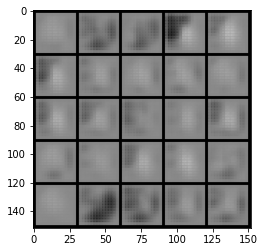

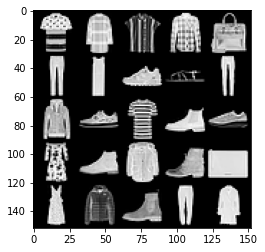

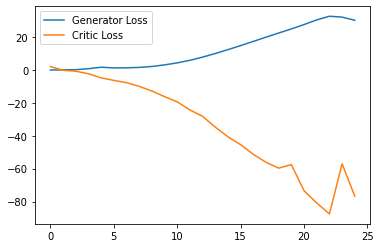

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 31.158566371917725, Critic loss: -17.997581654042005


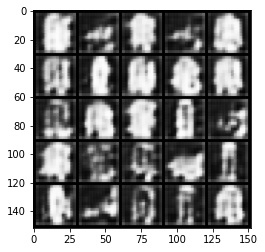

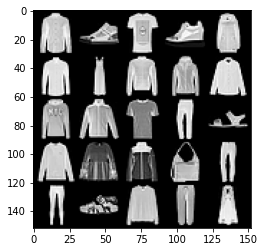

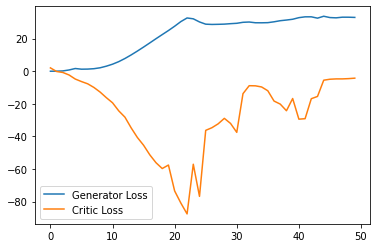

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 31.078198822021484, Critic loss: -2.0086297036111356


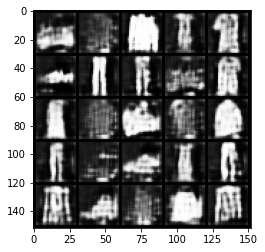

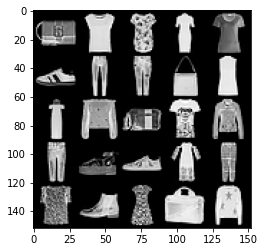

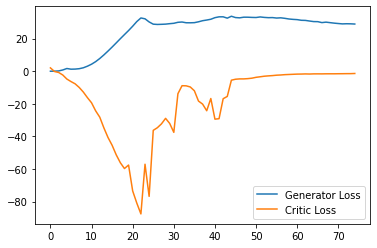

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 26.63167692565918, Critic loss: -1.2435162124186754


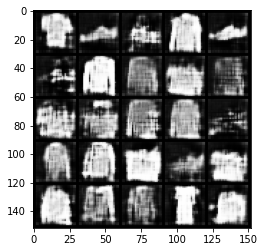

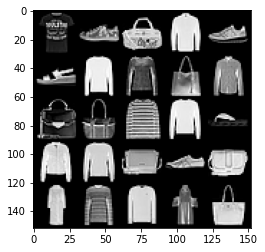

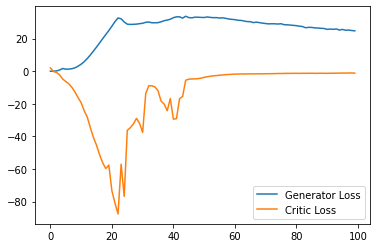

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 23.15806941986084, Critic loss: -1.1547326780855656


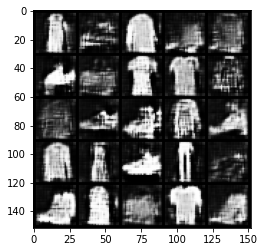

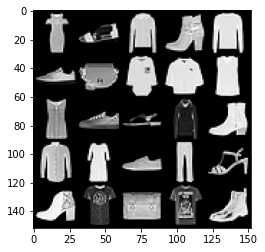

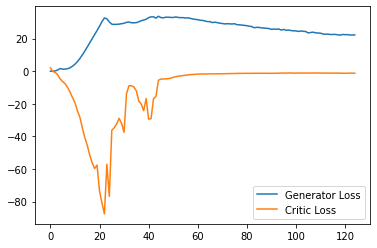

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 22.353997276306153, Critic loss: -1.236108431763947


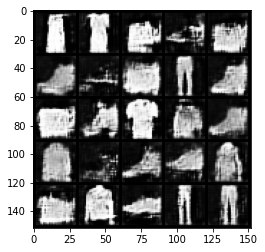

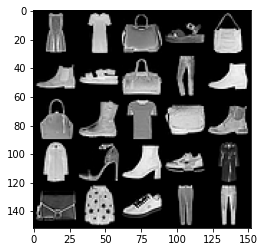

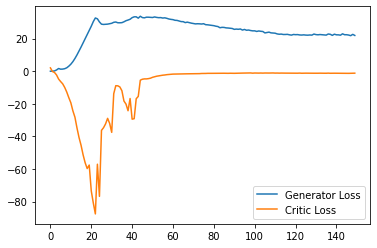

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 21.60586632537842, Critic loss: -1.176067448809743


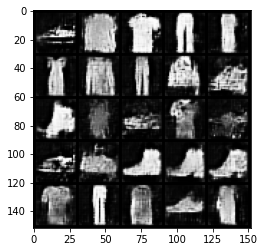

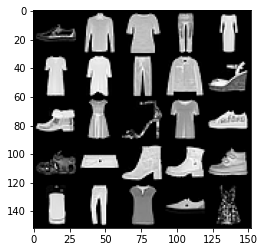

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 21.09044295501709, Critic loss: -0.9168493801448494


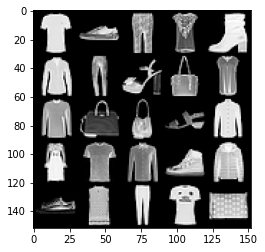

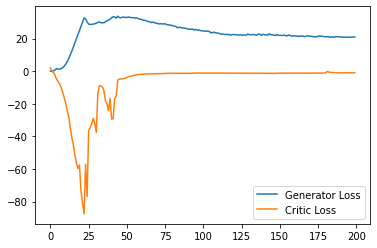

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 20.747529567718505, Critic loss: -0.8928568504303693


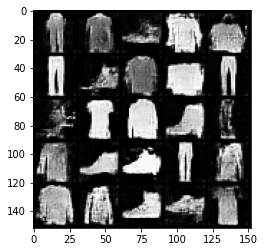

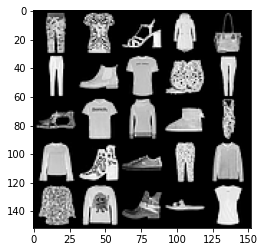

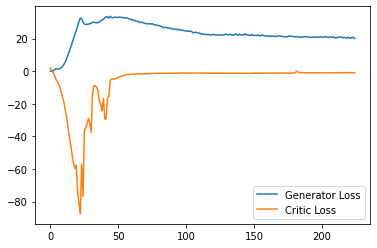

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 19.581899070739745, Critic loss: -0.8248901402689517


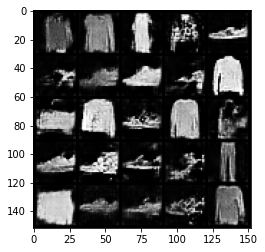

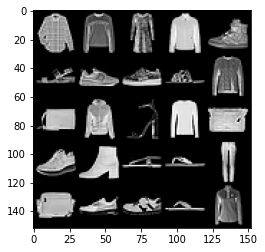

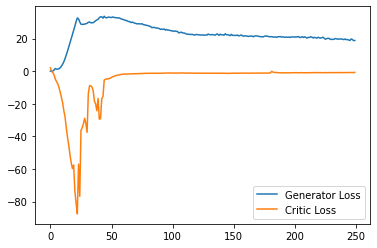

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 18.523119539260865, Critic loss: -0.7316225135624409


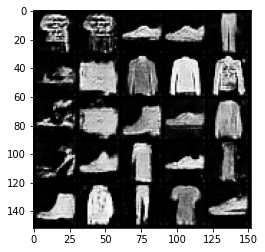

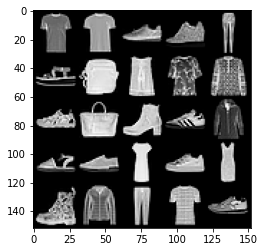

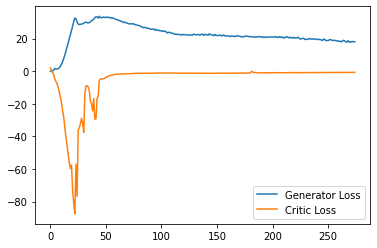

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 17.974027730941774, Critic loss: -0.6673038955815136


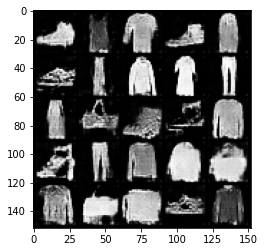

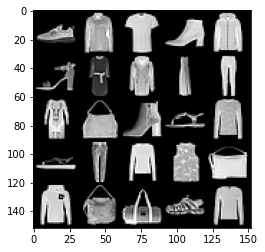

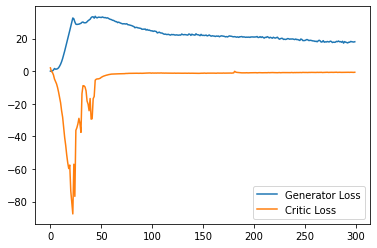

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 17.553226560592652, Critic loss: -0.6070920291971416


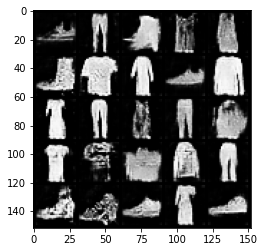

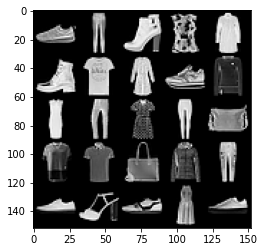

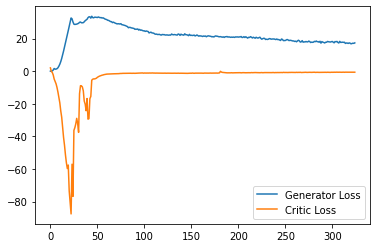

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 16.51916547203064, Critic loss: -0.5548388252211734


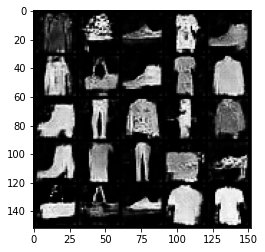

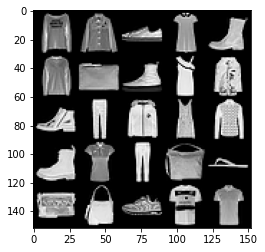

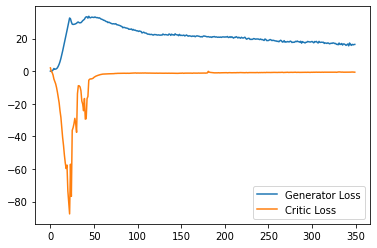

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 15.867255786895752, Critic loss: -0.5328476632498205


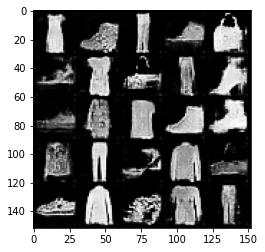

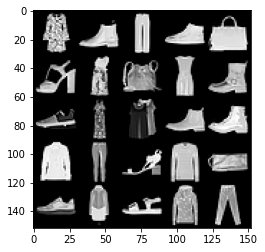

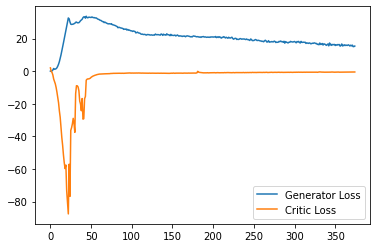

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 15.472138067245483, Critic loss: -0.5111782967085019


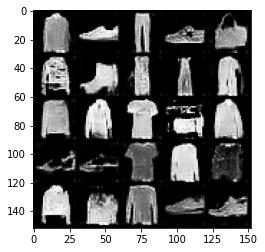

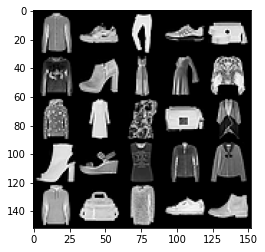

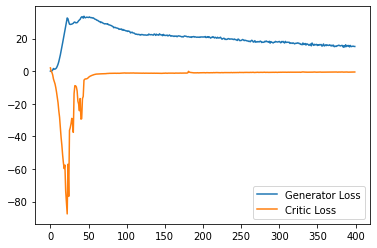

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 14.68569284248352, Critic loss: -0.4864396457001567


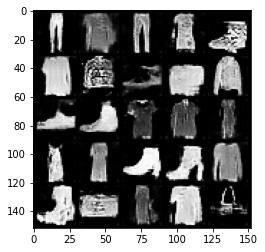

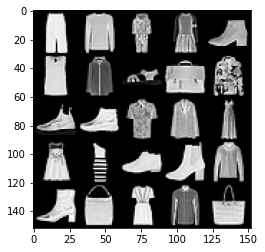

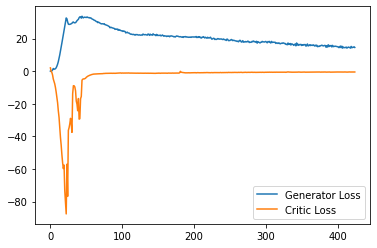

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 14.096754615783691, Critic loss: -0.4209310233164579


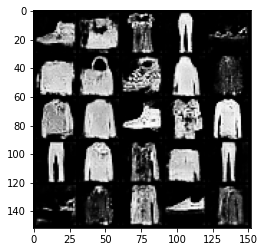

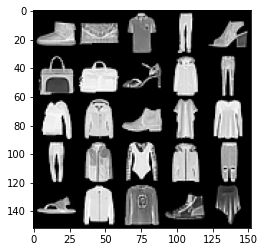

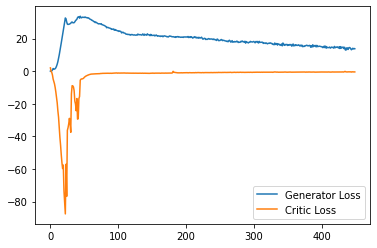

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 13.46859817314148, Critic loss: -0.4297554297475144


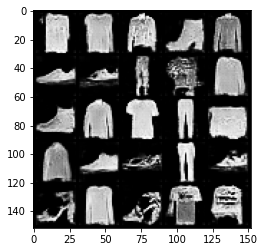

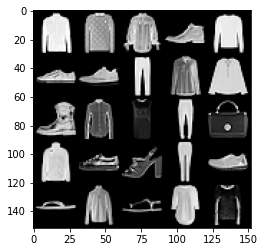

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 12.738725896835327, Critic loss: -0.4315140971718356


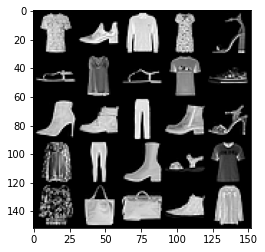

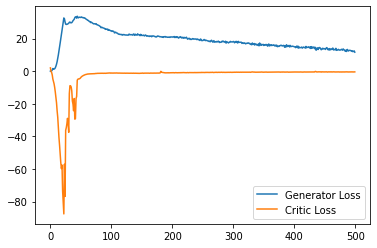

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 12.200871648788452, Critic loss: -0.4127455582851544


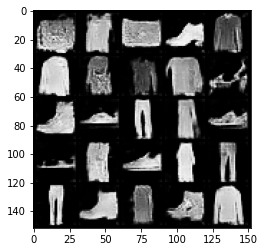

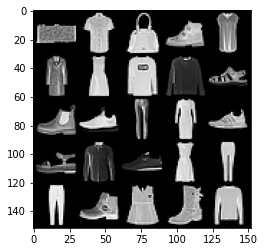

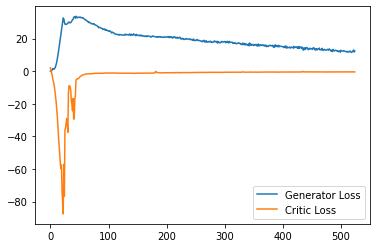

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 12.097560094833375, Critic loss: -0.40011624025553466


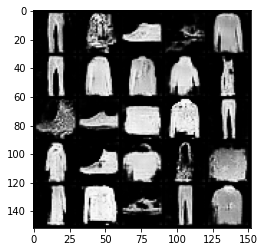

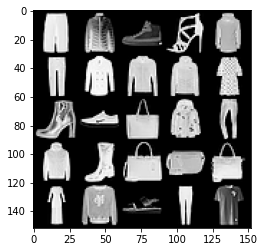

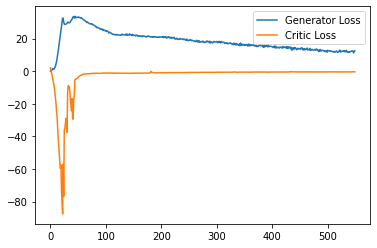

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 11.82747418308258, Critic loss: -0.37745574696082623


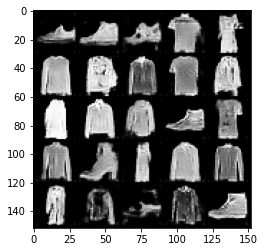

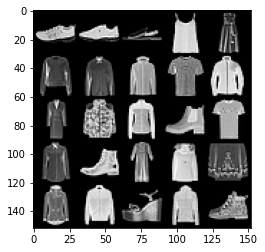

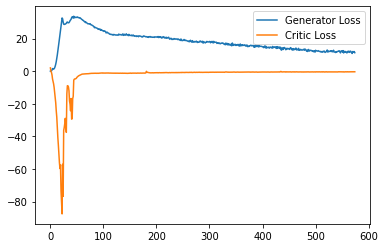

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 11.779129447937011, Critic loss: -0.38813950202520936


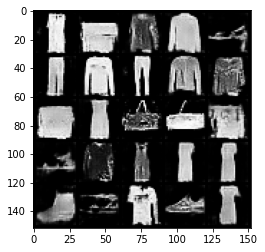

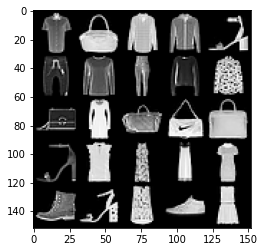

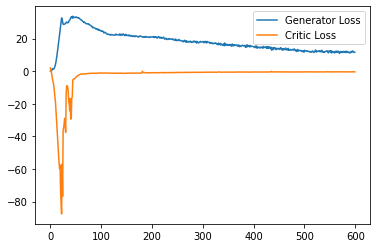

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 12.014920942306519, Critic loss: -0.3640203814445995


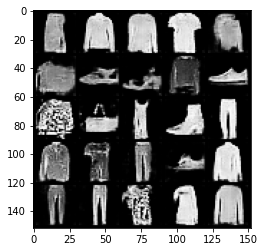

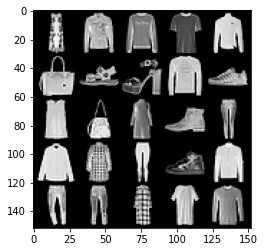

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 12.000724519729614, Critic loss: -0.35136435165023433


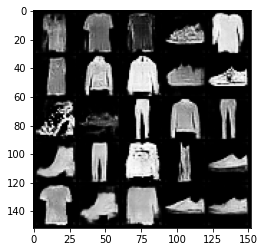

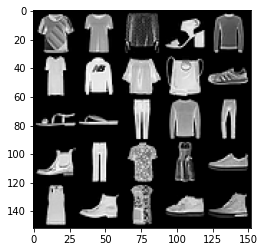

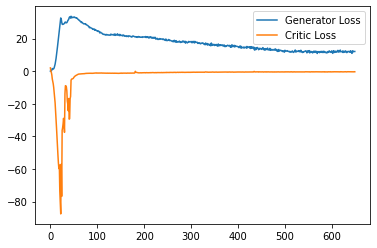

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 11.93746863746643, Critic loss: -0.3387391954353079


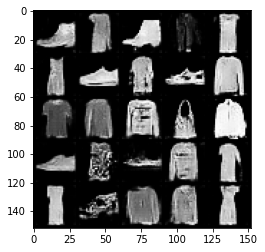

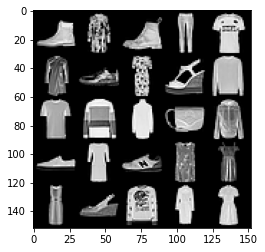

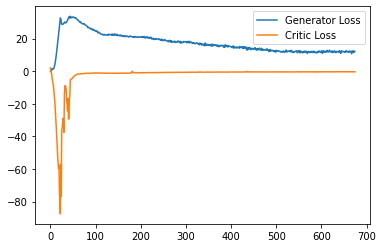

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 12.094742422103883, Critic loss: -0.33454929031571373


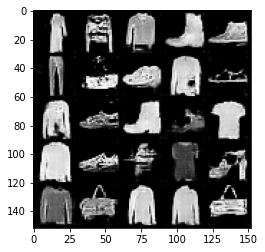

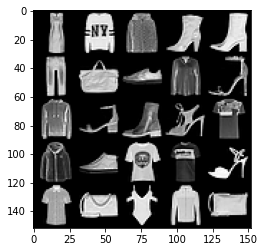

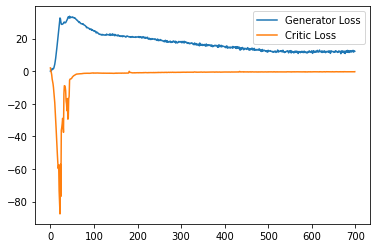

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 11.694538955688477, Critic loss: -0.34120396892726423


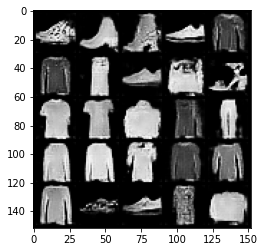

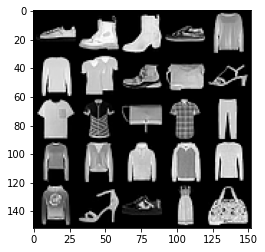

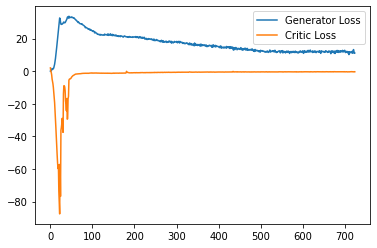

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 11.463167387962342, Critic loss: -0.32780914758192375


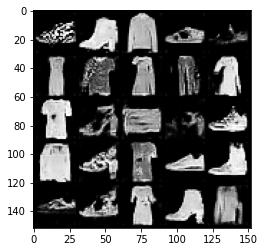

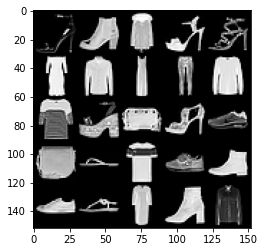

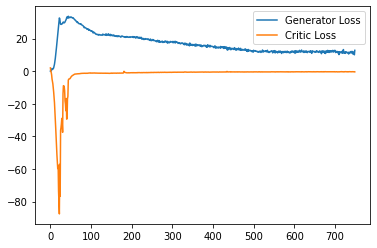

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 11.995065057754516, Critic loss: -0.3133843461596407


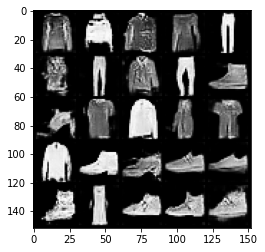

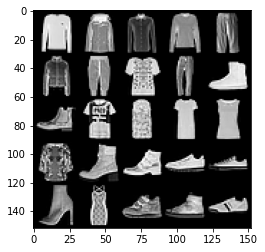

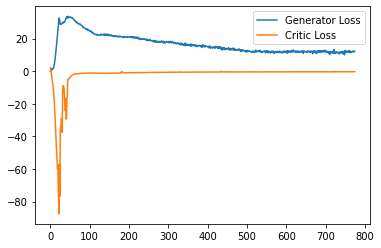

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 11.992351499557495, Critic loss: -0.3267046995679848


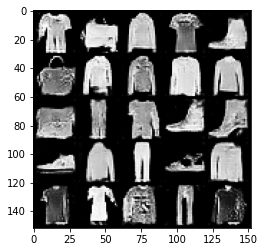

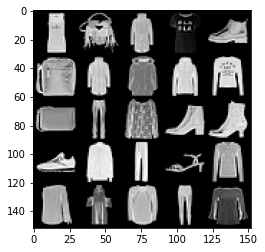

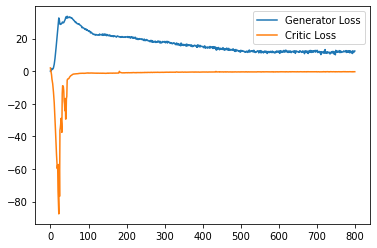

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 12.172976617813111, Critic loss: -0.3082241912181489


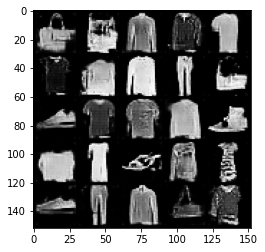

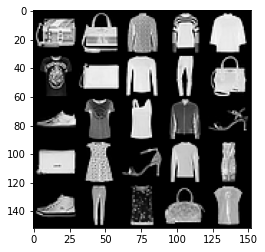

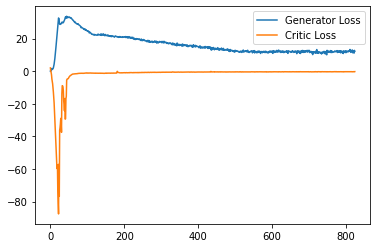

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 12.325913131713866, Critic loss: -0.3156483021816239


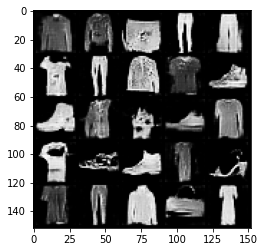

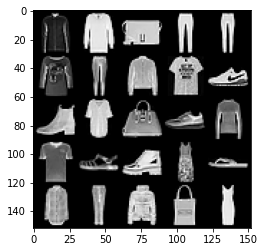

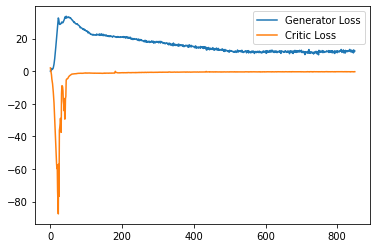

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 12.121159376144409, Critic loss: -0.2949399059349671


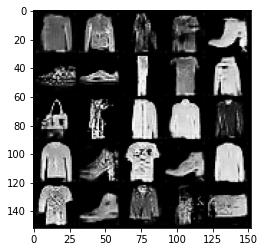

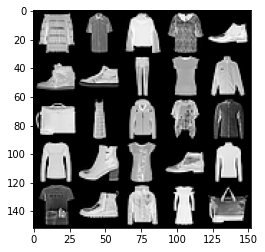

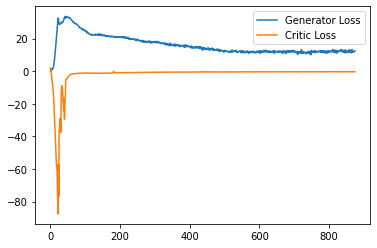

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 12.131825008392333, Critic loss: -0.2984659759528004


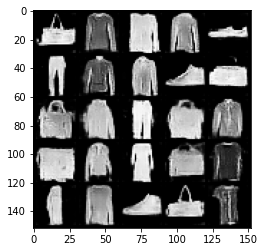

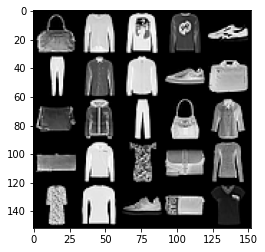

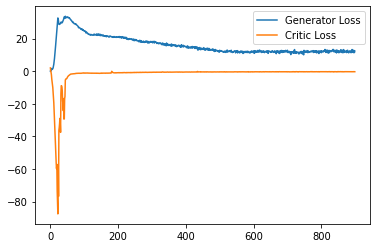

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [17]:
cur_step = 0
generator_losses = []
critic_losses = []

# Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels = labels.to(device), n_classes = n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, fashion_mnist_shape[1], fashion_mnist_shape[2])

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            # Update critic
            crit_opt.zero_grad()
            fake_noise = get_noise(n_samples = cur_batch_size, z_dim = z_dim, device = device)
            noise_and_labels = combine_vectors(x = fake_noise, y = one_hot_labels)
            fake = gen(noise_and_labels)
            fake_image_and_labels = combine_vectors(x = fake, y = image_one_hot_labels)
            real_image_and_labels = combine_vectors(x = real, y = image_one_hot_labels)
            crit_fake_pred = crit(fake_image_and_labels.detach())
            crit_real_pred = crit(real_image_and_labels)

            epsilon = torch.rand(len(real), 1, 1, 1, device = device, requires_grad = True)
            gradient = get_gradient(crit = crit, real = real_image_and_labels, fake = fake_image_and_labels.detach(), 
                                    epsilon = epsilon)
            gp = gradient_penalty(gradient = gradient)
            crit_loss = get_crit_loss(crit_fake_pred = crit_fake_pred, 
                                      crit_real_pred = crit_real_pred, gp = gp, 
                                      c_lambda = c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph = True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        # Update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(n_samples = cur_batch_size, z_dim = z_dim, device = device)
        noise_and_labels2 = combine_vectors(x = fake_noise_2, y = one_hot_labels)
        fake_2 = gen(noise_and_labels2)
        fake_image_and_labels2 = combine_vectors(x = fake_2, y = image_one_hot_labels)
        crit_fake_pred = crit(fake_image_and_labels2)
        
        gen_loss = get_gen_loss(crit_fake_pred = crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            critic_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, Critic loss: {critic_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(range(num_examples // step_bins), 
                     torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                     label = "Generator Loss")
            plt.plot(range(num_examples // step_bins), 
                     torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                     label = "Critic Loss")
            plt.legend()
            plt.show()

        cur_step += 1


### Exploration

In [18]:
gen = gen.eval()

### Changing the Class Vector

In [19]:
dataset_size = (1, 28, 28)

def show_tensor_images(image_tensor, num_images = 25, size = dataset_size, nrow = 5, show = True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow = nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

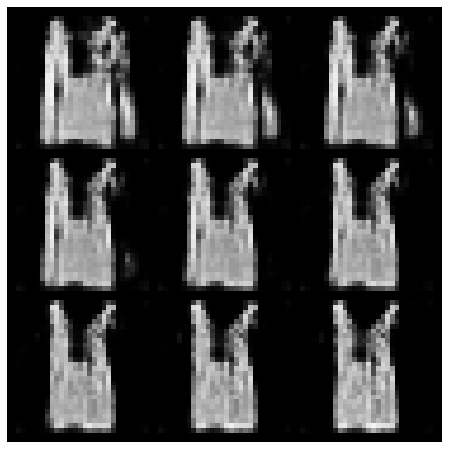

In [22]:
import math

# Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
n_interpolation = 9 
interpolation_noise = get_noise(1, z_dim, device = device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images = n_interpolation, nrow = int(math.sqrt(n_interpolation)), show = False)

# Choose the start digit
start_plot_number = 2
# Choose the end digit
end_plot_number = 6

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Changing the Noise Vector

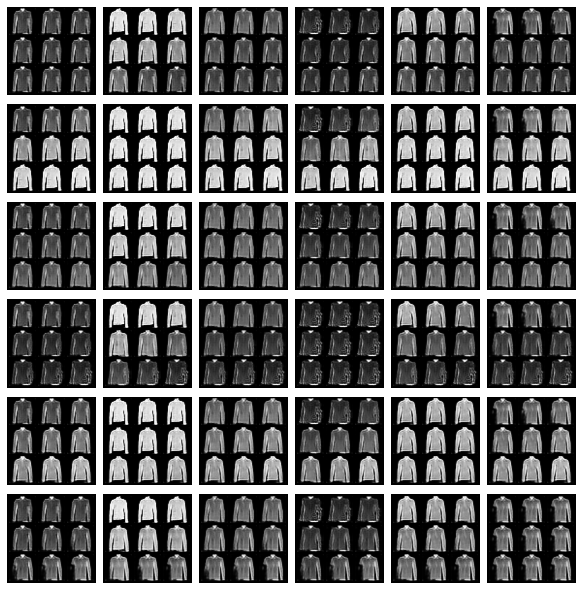

In [23]:
# How many intermediate images you want + 2 (for the start and end image)
n_interpolation = 9
# Choose the number of noise examples in the grid
n_noise = 6

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([n_noise]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow = int(math.sqrt(n_interpolation)), show = False)

# Generate noise vectors to interpolate between
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

### Save Model

In [24]:
torch.save(gen.state_dict(), f = 'gen_conditional_wgan_gp_sngan_fashion_mnist.pth')
torch.save(crit.state_dict(), f = 'critic_conditional_wgan_gp_sngan_fashion_mnist.pth')